In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

In [2]:
from openai import OpenAI
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [3]:
user_train_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/user_train.json'
user_valid_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/user_valid.json'
user_test_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/user_test.json'

In [4]:
with open(user_train_path, 'rb') as f:
    user_train_dict = json.load(f)
with open(user_valid_path, 'rb') as f:
    user_valid_dict = json.load(f)
with open(user_test_path, 'rb') as f:
    user_test_dict = json.load(f)

In [5]:
user_id = '1'
print(user_train_dict[user_id])
print(user_valid_dict[user_id])
print(user_test_dict[user_id])

[7, 8, 9, 9, 10]
[7, 8, 9, 9, 10, 11]
[8, 9, 9, 10, 11, 12]


In [6]:
item_information_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/processed_item_information.json'
with open(item_information_path, 'r') as f:
    item_information_dict = json.load(f)
print(len(item_information_dict))

1216


In [7]:
ratings_path = '../../beauty_data/processed_data/ratings.csv'
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,item,user,rating,timestamp
0,0,0,4.0,1155081600
1,1,0,5.0,1268697600
2,2,0,5.0,1404604800
3,3,0,5.0,1404604800
4,4,0,5.0,1404604800


In [9]:
def get_item_description(item_information):
    item_details = ""
    if 'title' in item_information:
        item_details += item_information['title']
    if 'brand' in item_information:
        item_details += f" Brand: {item_information['brand']}"
    if 'price' in item_information:
        item_details += f" Price: {item_information['price']}"
    # if 'description' in item_information:
    #     item_details += f" Description: {item_information['description']}"
    return item_details

In [10]:
user_profile_summary_path = '../../beauty_data/processed_data/user_profile_summary.json'
with open(user_profile_summary_path, 'r') as f:
    user_profile_summary_dict = json.load(f)
print(len(user_profile_summary_dict), user_profile_summary_dict['1'])

160 

The user dislikes products that do not meet expectations, as seen with the 100% Cotton Premium Salon Towels. Despite being soft and thick, the towels unraveled after the first wash, which was disappointing for the user. The user seems to value durability and quality in their purchases.


In [11]:
### Train Data Reaosning
train_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_train_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    if user in user_profile_summary_dict:
        prompt = f"""You are an expert beauty product recommender. You are provided with a user's profile and list of recent products that the user purchases and whether the user liked it or disliked it.
        User Profile - {user_profile_summary_dict[user]}
        User purchased the following items in the given order. List of recent items -
        """
    else:
        prompt = """You are an expert beauty product recommender. You are provided with user's list of recent products that the user purchases and whether the user liked it or disliked it.
        User purchased the following items in the given order. List of recent items -
        """
    for item in item_list[:-1]:
        try:
            user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        except Exception as e:
            print(f"User: {user} Item: {item} error {e}")
            continue
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    if str(target_item) not in item_information_dict:
        continue
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    train_reasoning_prompts[user] = [prompt, recommendation]
    # break
# print(train_reasoning_prompts)

User: 64 Item: 229 error index 0 is out of bounds for axis 0 with size 0
User: 215 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 274 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 401 Item: 880 error index 0 is out of bounds for axis 0 with size 0
User: 427 Item: 399 error index 0 is out of bounds for axis 0 with size 0


In [12]:
total_len = 0
all_prompt_lens = []
for user, prompt in train_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(train_reasoning_prompts))

274.54647435897436


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   3.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,
          2.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   2.,   0.,   3.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   4.,   0.,   0.,   1.,
          0.,   2.,   0.,   0.,   2.,   0.,   3.,   0.,   0.,   3.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          2.,   0.,   0.,   2.,   0.,   2.,   0.,   0.,   2.,   0.,   4.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   2.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   3.,   0.,   2.,   0.,
          0.,   2.,   0.,   0.,   1.,   0.,   3.,   0.,   0.,   5.,   0.,
          5.,   0.,   0.,   2.,   0.,   0., 102.,   0., 202.,   0.,   0.,
          3.,   0.,   5.,   0.,   0., 

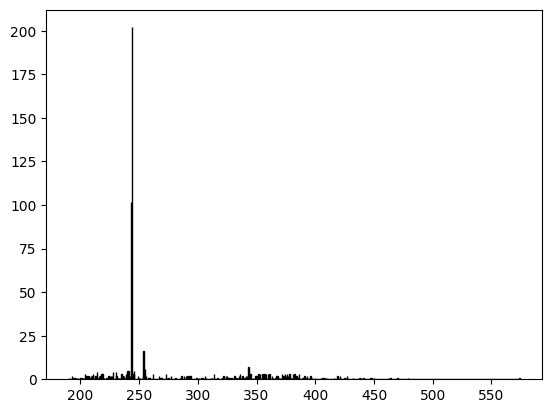

In [13]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [14]:
### Valid Data Reaosning
valid_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_valid_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    if user in user_profile_summary_dict:
        prompt = f"""You are an expert beauty product recommender. You are provided with a user's profile and list of recent products that the user purchases and whether the user liked it or disliked it.
        User Profile - {user_profile_summary_dict[user]}
        User purchased the following items in the given order. List of recent items -
        """
    else:
        prompt = """You are an expert beauty product recommender. You are provided with user's list of recent products that the user purchases and whether the user liked it or disliked it.
        User purchased the following items in the given order. List of recent items -
        """
        
    for item in item_list[:-1]:
        try:
            user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        except Exception as e:
            print(f"User: {user} Item: {item} error {e}")
            continue
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    if str(target_item) not in item_information_dict:
        continue
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    valid_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(valid_reasoning_prompts))

User: 64 Item: 229 error index 0 is out of bounds for axis 0 with size 0
User: 215 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 401 Item: 880 error index 0 is out of bounds for axis 0 with size 0
User: 427 Item: 399 error index 0 is out of bounds for axis 0 with size 0
624


In [15]:
total_len = 0
all_prompt_lens = []
for user, prompt in valid_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(valid_reasoning_prompts))

287.02884615384613


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   3.,   0.,
          3.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   5.,   0.,
          2.,   0.,   0.,   0.,   0.,   3.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   3.,   0.,   4.,   0.,   3.,   0.,   0.,
          3.,   0.,   4.,   0.,   0.,   0.,   0., 198.,   0.,   0.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   2.,   0.,   2.,   0.,   0.,
          2.,   0.,   5.,   0.,   0., 

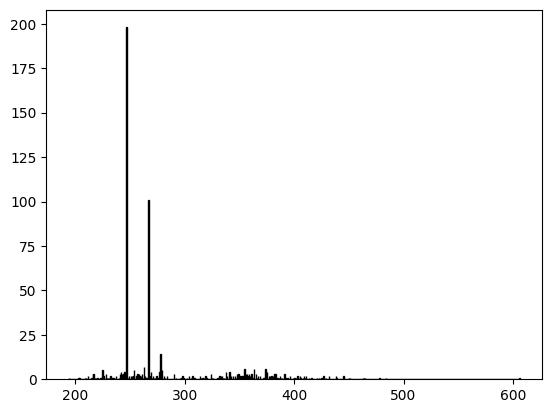

In [16]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [17]:
### Test Data Reaosning
test_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_test_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    if user in user_profile_summary_dict:
        prompt = f"""You are an expert beauty product recommender. You are provided with a user's profile and list of recent products that the user purchases and whether the user liked it or disliked it.
        User Profile - {user_profile_summary_dict[user]}
        User purchased the following items in the given order. List of recent items -
        """
    else:
        prompt = """You are an expert beauty product recommender. You are provided with user's list of recent products that the user purchases and whether the user liked it or disliked it.
        User purchased the following items in the given order. List of recent items -
        """
    for item in item_list[:-1]:
        try:
            user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        except Exception as e:
            print(f"User: {user} Item: {item} error {e}")
            continue
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    if str(target_item) not in item_information_dict:
        continue
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    test_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(test_reasoning_prompts))

User: 64 Item: 229 error index 0 is out of bounds for axis 0 with size 0
User: 215 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 401 Item: 880 error index 0 is out of bounds for axis 0 with size 0
User: 427 Item: 399 error index 0 is out of bounds for axis 0 with size 0
622


In [18]:
total_len = 0
all_prompt_lens = []
for user, prompt in test_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(test_reasoning_prompts))

299.387459807074


(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  3.,  0.,  2.,  0.,  2.,  0.,  0.,  1.,  0.,  2.,  0.,
         1.,  0.,  0.,  1.,  0.,  2.,  0., 13.,  0.,  1.,  0.,  0.,  5.,
         0.,  7.,  0.,  2.,  0.,  0.,  7.,  0.,  5.,  0.,  9.,  0.,  0.,
        19.,  0.,  7.,  0., 10.,  0.,  0.,  4.,  0., 18.,  0., 14.,  0.,
         0., 31.,  0.,  8.,  0., 28.,  0.,  0., 34.,  0.,  3.,  0., 12.,
         0., 28.,  0.,  0.,  5.,  0., 12.,  0.,  5.,  0.,  0.,  4.,  0.,
        10.,  0.,  3.,  0.,  0.,  4.,  0.,  4.,  0., 15.,  0.,  0.,  3.,
         0., 16.,  0.,  3.,  0.,  0.,  4.,  0.,  1.,  0.,  4.,  0.,  3.,
         0.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  0.

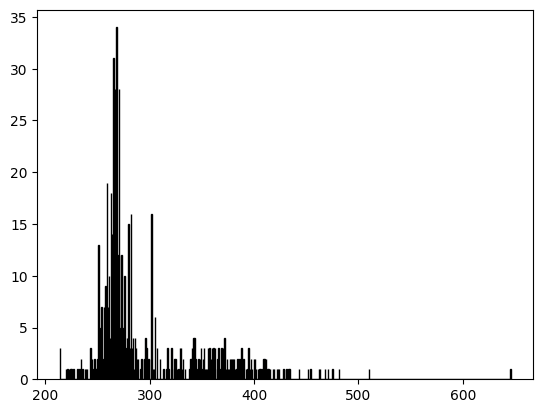

In [19]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [20]:
very_long_prompts_users = set()
len_threshold = 500
for user, prompt in test_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)
for user, prompt in train_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)
for user, prompt in valid_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)

In [21]:
very_long_prompts_users = list(very_long_prompts_users)
print(len(very_long_prompts_users))

2


In [22]:
for user in very_long_prompts_users:
    train_reasoning_prompts.pop(user, None)
    valid_reasoning_prompts.pop(user, None)
    test_reasoning_prompts.pop(user, None)
print(len(train_reasoning_prompts), len(valid_reasoning_prompts), len(test_reasoning_prompts))

622 622 620


In [23]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_train.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(train_reasoning_prompts, f)
    f.close()

In [24]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_valid.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(valid_reasoning_prompts, f)
    f.close()

In [25]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_test.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(test_reasoning_prompts, f)
    f.close()

In [26]:
user = '32'
print(train_reasoning_prompts[user])
print(valid_reasoning_prompts[user])
print(test_reasoning_prompts[user])

["You are an expert beauty product recommender. You are provided with user's list of recent products that the user purchases and whether the user liked it or disliked it.\n        User purchased the following items in the given order. List of recent items -\n        Liked Philips Norelco Speed-XL 8240 Men's Shaving System Brand: Philips Norelco Price: $29.35\nLiked Braun Clean &amp; Renew Refill Cartridges CCR - 2 Count (Packaging May Vary) Brand: Braun Price: $11.94\nLiked Williams Lectric Shave, 7 Ounce Brand: Williams Price: \nNow, we know that the user will LIKE the next item - Williams Lectric Shave, 7 Ounce Brand: Williams Price: \n        As an expert fashion product recommender, do the following steps -\n        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.\n        2. Explain with reasoning why the user will like the next i

In [27]:
user = '32'
content = train_reasoning_prompts[user][0]
groundtruth = train_reasoning_prompts[user][1]
print(content)
print('*'*100)
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "user",
      "content": content
    }
  ],
  temperature=0,
  max_tokens=256,
  top_p=0.75
)


response = response.choices[0].message.content
print(response)
len(response.split(' '))

You are an expert beauty product recommender. You are provided with user's list of recent products that the user purchases and whether the user liked it or disliked it.
        User purchased the following items in the given order. List of recent items -
        Liked Philips Norelco Speed-XL 8240 Men's Shaving System Brand: Philips Norelco Price: $29.35
Liked Braun Clean &amp; Renew Refill Cartridges CCR - 2 Count (Packaging May Vary) Brand: Braun Price: $11.94
Liked Williams Lectric Shave, 7 Ounce Brand: Williams Price: 
Now, we know that the user will LIKE the next item - Williams Lectric Shave, 7 Ounce Brand: Williams Price: 
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - Will

131